In [1]:
import pandas as pd
import numpy as np

from keras import Input
from keras.engine import Model
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Concatenate, concatenate
from keras.callbacks import TensorBoard

import h5py

Using TensorFlow backend.


In [2]:
# features is a list of strings of feature names 

def build_model(features, data_length, label_length):
    
    inputs_list = [] 
    for feature_name in features:
        inputs_list.append((Input(shape=(data_length,1), name=feature_name)))
    
    layers = [] 
    for i, input_name in enumerate(inputs_list): 
        layers.append(LSTM(64, return_sequences=False)(inputs_list[i]) )
        
    output = concatenate(layers) 
    output = Dense(label_length, activation='linear', name='weighted_average_output')(output)
    
    model = Model(
        inputs = inputs_list,
        outputs = [output]
    )
    
    model.compile(optimizer='rmsprop', loss='mse')
    
    return model    
        
data_length = 10
label_length = 10

In [3]:
from sklearn.preprocessing import MinMaxScaler

master_df = pd.read_csv('C:/Users/Shoya/surf/data/master_df.csv', encoding='latin1')
df = master_df[['Timestamp', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Date(UTC)', 'Bitcoin (Adj.Overlap)', 
               'Close Price % Change', 'Close Price % Change (Abs)', 'Is Spike']]

# lag price 
df['Price_lagged'] = df['Close'].shift(1)

df = df.dropna()

df['Volume_BTC'] = df['Volume_(BTC)']
df['Bitcoin_Adj'] = df['Bitcoin (Adj.Overlap)']

cols = ['Volume_BTC','Bitcoin_Adj', 'Close', 'Price_lagged']

# Stationalize Data by taking log differences
data_array = np.diff(np.log(df[cols]), axis=0)

# Min-Max Scale 

scalers = {}
datas = [] 

df_scaled = pd.DataFrame(columns=cols)

for i in range(len(cols)): 
    scalers[cols[i]] = MinMaxScaler()
    print('data', data_array[:,i])
    
    col_data = data_array[:,i]
    col_data = np.reshape(col_data, (len(col_data), 1))
    
    data = scalers[cols[i]].fit_transform( col_data )  #:, np.newaxis
    print('scaled', data)
    data = np.reshape(data, (1, len(data)))
    df_scaled[cols[i]] = data[0]
    

# for data in datas:
#     data_scaled = np.concatenate((data_scaled, data), axis=1)

# scaler = MinMaxScaler() 
# data_scaled = scaler.fit_transform(data_array)
# df_scaled = pd.DataFrame(data_scaled, columns=cols)

display(df_scaled.head())

# results in 0s ?? 
# scaler_y = MinMaxScaler()
# scaler_y.fit_transform( [np.float32( np.diff(np.log(df['Close'] )  , axis=0)  )])




# cols = ['Timestamp','Volume_BTC', 'Bitcoin_Adj', 'Close']

# for col in cols:
#     df[col] = scaler.fit_transform([df[col].values])

# X = df[['Timestamp', 'Volume_BTC', 'Bitcoin_Adj']].values
# Y = df['Close'].values


# X_train, X_test = X[1:train_size], X[train_size:len(X)]
# Y_train, Y_test = Y[1:train_size], Y[train_size:len(X)]
# print('Observations: %d' % (len(X)))
# print('Training Observations: %d' % (len(X_train)))
# print('Testing Observations: %d' % (len(Y_test)))


data [-5.44587603  5.27859267 -1.39306384 ..., -0.86772309  0.52915484
  2.21562315]
scaled [[ 0.27288984]
 [ 0.77679111]
 [ 0.4633158 ]
 ..., 
 [ 0.48799952]
 [ 0.55363341]
 [ 0.63287403]]
data [ 0.          0.07410797 -0.05505978 ...,  0.12921173  0.02985296  0.        ]
scaled [[ 0.4536254 ]
 [ 0.47196961]
 [ 0.43999626]
 ..., 
 [ 0.48560964]
 [ 0.46101501]
 [ 0.4536254 ]]
data [ 0.00593818 -0.0164329  -0.00176565 ..., -0.00139514  0.03764151
 -0.00345164]
scaled [[ 0.56657518]
 [ 0.48455698]
 [ 0.53833093]
 ..., 
 [ 0.53968931]
 [ 0.68280789]
 [ 0.53214965]]
data [ 0.01039096  0.00593818 -0.0164329  ..., -0.00379381 -0.00139514
  0.03764151]
scaled [[ 0.58290022]
 [ 0.56657518]
 [ 0.48455698]
 ..., 
 [ 0.53089518]
 [ 0.53968931]
 [ 0.68280789]]


C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Volume_BTC,Bitcoin_Adj,Close,Price_lagged
0,0.272890,0.453625,0.566575,0.582900
1,0.776791,0.471970,0.484557,0.566575
2,0.463316,0.439996,0.538331,0.484557
3,0.725079,0.529463,0.520715,0.538331
4,0.210661,0.416611,0.566098,0.520715


In [4]:
# split and reshape data to feed into RNN

X_timestamp = df['Timestamp'].values
X_volume = df['Volume_BTC'].values
X_trends = df['Bitcoin_Adj'].values
X_lagged_price = df['Price_lagged'].values

Y_price = df['Close'].values

train_size = int(len(X_timestamp) * 0.85)
train_size = int(train_size/10) * 10 

test_size_index = int(len(X_timestamp)/10)*10

X_train_timestamp, X_test_timestamp = X_timestamp[:train_size], X_timestamp[train_size:test_size_index ]
X_train_volume, X_test_volume = X_volume[:train_size], X_volume[train_size:test_size_index ]
X_train_trends, X_test_trends = X_trends[:train_size], X_trends[train_size:test_size_index ]
X_train_lagged_price, X_test_lagged_price = X_lagged_price[:train_size], X_lagged_price[train_size:test_size_index ]

Y_train_price, Y_test_price = Y_price[:train_size], Y_price[train_size:test_size_index ]


# X.shape is (samples, timesteps, dimension) 
# timestemps is 15, samples is just however many nobs there are (but it doesn't matter, so it should be None)



X_train_timestamp = np.reshape(X_train_timestamp, (int(X_train_timestamp.shape[0]/data_length),data_length,1) ) 
X_train_volume = np.reshape(X_train_volume, (int(X_train_volume.shape[0]/data_length),data_length,1) ) 
X_train_trends = np.reshape(X_train_trends, (int(X_train_trends.shape[0]/data_length),data_length,1) ) 
X_train_lagged_price = np.reshape(X_train_lagged_price, (int(X_train_lagged_price.shape[0]/data_length), data_length, 1))

X_test_timestamp = np.reshape(X_test_timestamp, (int(X_test_timestamp.shape[0]/data_length),data_length,1) ) 
X_test_volume = np.reshape(X_test_volume, (int(X_test_volume.shape[0]/data_length),data_length,1) ) 
X_test_trends = np.reshape(X_test_trends, (int(X_test_trends.shape[0]/data_length),data_length,1) )  
X_test_lagged_price = np.reshape(X_test_lagged_price, (int(X_test_lagged_price.shape[0]/data_length),data_length,1))


# Don't need the 1 for the third dimension for Y's??


Y_train_price = np.reshape(Y_train_price, (int(Y_train_price.shape[0]/data_length),  data_length) ) 
Y_test_price = np.reshape(Y_test_price, (int(Y_test_price.shape[0]/data_length),  data_length) ) 

In [6]:
features = ['Volume_BTC', 'Bitcoin_Adj', 'Price_lagged']

rnn = build_model(features, 10, 10) 

tensorboard_callback = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

history = rnn.fit(
    [
        #X_train_timestamp,
        X_train_volume,
        X_train_trends,
        X_train_lagged_price
    ],
    [
        Y_train_price
    ]
    ,
    validation_data=(
        [
            #X_test_timestamp,
            X_test_volume,
            X_test_trends,
            X_test_lagged_price
        ],
        [
            Y_test_price
        ]),
    epochs=120,
    batch_size=32,
    callbacks=[
      tensorboard_callback
    ],
    verbose=1
)


Train on 2386 samples, validate on 421 samples
Epoch 1/120
2386/2386 [==============================] - 3s - loss: 1799054.6865 - val_loss: 112387622.1188
Epoch 2/120
2386/2386 [==============================] - 3s - loss: 1784264.4891 - val_loss: 112232415.6580
Epoch 3/120
2386/2386 [==============================] - 3s - loss: 1770930.8477 - val_loss: 112081515.1734
Epoch 4/120
2386/2386 [==============================] - 3s - loss: 1757958.7420 - val_loss: 111935500.5986
Epoch 5/120
2386/2386 [==============================] - 3s - loss: 1744954.4524 - val_loss: 111783846.0048
Epoch 6/120
2386/2386 [==============================] - 3s - loss: 1732081.7298 - val_loss: 111634925.4727
Epoch 7/120
2386/2386 [==============================] - 3s - loss: 1719363.6318 - val_loss: 111485637.5867
Epoch 8/120
2386/2386 [==============================] - 3s - loss: 1706518.0897 - val_loss: 111336272.1140
Epoch 9/120
2386/2386 [==============================] - 3s - loss: 1694333.3471 - val_lo

2386/2386 [==============================] - 3s - loss: 1126308.8175 - val_loss: 101908290.4418
Epoch 76/120
2386/2386 [==============================] - 3s - loss: 1121655.1943 - val_loss: 101782052.1140
Epoch 77/120
2386/2386 [==============================] - 3s - loss: 1116856.6041 - val_loss: 101653603.9715
Epoch 78/120
2386/2386 [==============================] - 3s - loss: 1112501.2314 - val_loss: 101533694.4988
Epoch 79/120
2386/2386 [==============================] - 3s - loss: 1108120.8808 - val_loss: 101406119.5154
Epoch 80/120
2386/2386 [==============================] - 3s - loss: 1103874.5533 - val_loss: 101282837.1496
Epoch 81/120
2386/2386 [==============================] - 3s - loss: 1099722.7548 - val_loss: 101153769.1971
Epoch 82/120
2386/2386 [==============================] - 3s - loss: 1095565.5450 - val_loss: 101033130.6318
Epoch 83/120
2386/2386 [==============================] - 3s - loss: 1091654.9973 - val_loss: 100910030.1283
Epoch 84/120
2386/2386 [========

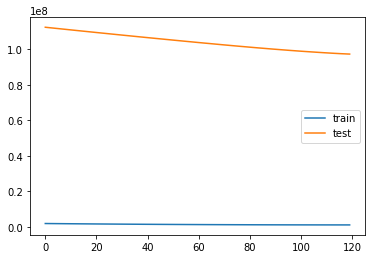

In [7]:
from matplotlib import pyplot as plt

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [8]:
score = rnn.evaluate(
    [
        #X_test_timestamp,
        X_test_volume,
        X_test_trends,
        X_test_lagged_price
    ],
    [
        Y_test_price
    ])

print(score)

320/421 [=====================>........] - ETA: 0s97269843.2494


In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt 

yhat = rnn.predict( 
    [
        #X_test_timestamp,
        X_test_volume,
        X_test_trends,
        X_test_lagged_price
    ],
    verbose=2
)

# invert scaling 
inv_yhat = yhat.reshape((test_size_index - train_size, 1 ))# it forecasts the next 10 hours, so just reshape to 1D 
inv_yhat = scalers['Close'].inverse_transform(inv_yhat)  
yhat = np.exp(np.cumsum(inv_yhat)) # undo log difference to get original 

# predictions are so off that it overflows to become infinites when I invert them back to their original scale 

Y_test_price = Y_test_price.reshape((test_size_index - train_size, 1 ))
Y_test_price_inv = scalers['Close'].inverse_transform(Y_test_price) 
Y_test_price_inv = np.exp(np.cumsum( Y_test_price_inv   ))  

#Y_test_price_inv = np.exp(np.cumsum(   np.concatenate( ( df['Close'].iloc[0]  ,Y_test_price_inv )  )   ))  # np.concatenate(([x[0]], x_diff))

display(Y_test_price_inv, yhat)

rmse = sqrt(mean_squared_error(Y_test_price_inv[1:], yhat[1:]))
print('Test RMSE: %.3f' % rmse)

plt.plot(Y_test_price_inv, label='actual')
plt.plot(yhat, label='predicted')
plt.legend()
plt.show();



C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: overflow encountered in exp
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: overflow encountered in exp


array([ inf,  inf,  inf, ...,  inf,  inf,  inf])

array([ inf,  inf,  inf, ...,  inf,  inf,  inf], dtype=float32)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [43]:
# serialize model to JSON
model_json = rnn.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
rnn.save_weights("model.h5")


In [ ]:
# Probably need to change up x and y to frame it as a supervising problem -> look online to that one article
# also scale it from 0 to 1 
# remove seasonality 
# Change timestamp into some categorial input, not just a timestamp 

# look into if min-max scaling actually worked properly 

# Finally min-max scaled correctly so figure out how to unscale it (invert and undo log difference)